<a href="https://colab.research.google.com/github/pekgnee/Holistically-nested-edge-detection-for-flowers/blob/master/Holistically_nested_edge_detection_for_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Source
Colaboratory Notebooks for pix2pix
https://colab.research.google.com/github/anujdutt9/DeepLearning/blob/master/Colaboratory_Notebooks_for_pix2pix.ipynb

Edge detection with HED (holistically-nested edge detection)
https://colab.research.google.com/drive/1SI57hLgHCX6mbZ2jNveNvq1Pqx07Jag7

# Holistically-nested edge detection from pix2pix-tensorflow

![cat](https://i.imgur.com/0f7N7u8.png)

This is a Colaboratoly notebook that applies [holistically-nested edge detection](https://arxiv.org/abs/1504.06375) (HED) to a given set of images. It's originally implemented in [pix2pix-tensorflow](https://github.com/affinelayer/pix2pix-tensorflow), which is used to generate image pairs for training an *edges-to-something* pix2pix model.

Most parts of this notebook were copy-pasted from the original pix2pix-tensorflow code. The setup process is pretty complicated (it modifies and recompiles Caffe source code for customization) so that it requires a fair amount of time. The runtime part is also complicated. The processing time is not so impressive.

It works, but isn't recommended to use for other puposes.

## Settings

In [0]:
#@markdown This cell is to mount your Google Drive in Colaboratory. Run it and follow the instruction.

mount_point = '/content/gdrive' #@param {type:'string'}

import os
if os.path.isdir(mount_point):
  print(mount_point + ' has been already mounted.')
else:
  from google.colab import drive
  drive.mount(mount_point)

KeyboardInterrupt: ignored

In [0]:
#@markdown This cell contains some parameters. Update and run it.

input_dir = '/My Drive/Colab Datasets/Irasutoya/Preprocess' #@param {type:"string"}
input_dir = mount_point + input_dir

output_dir = '/My Drive/Colab Datasets/Irasutoya/HED' #@param {type:"string"}
output_dir = mount_point + output_dir

print(str(len(os.listdir(input_dir))) + " input files found.")

OSError: ignored

## Environment setup

This takes about 15~20 min to set the environment up.

In [0]:
CAFFE_ROOT='/opt/caffe'

!apt install -y --no-install-recommends \
  build-essential \
  cmake \
  libatlas-base-dev \
  libboost-all-dev \
  libgflags-dev \
  libgoogle-glog-dev \
  libhdf5-serial-dev \
  libleveldb-dev \
  liblmdb-dev \
  liboctave-dev \
  libopencv-dev \
  libprotobuf-dev \
  libsnappy-dev \
  octave \
  protobuf-compiler

!mkdir -p {CAFFE_ROOT}
%cd {CAFFE_ROOT}
!git clone https://github.com/s9xie/hed .
!git checkout 9e74dd710773d8d8a469ad905c76f4a7fa08f945
# https://github.com/s9xie/hed/pull/23
!sed -i "s|add_subdirectory(examples)||g" CMakeLists.txt
# https://github.com/s9xie/hed/issues/11
!sed -i "647s|//||" include/caffe/loss_layers.hpp
!sed -i "648s|//||" include/caffe/loss_layers.hpp
# keijiro: ad-hoc fix for compilation error
!sed -i "s|, 0.0|, Dtype(0.0)|" src/caffe/layers/contrastive_loss_layer.cpp

!mkdir {CAFFE_ROOT}/build
%cd {CAFFE_ROOT}/build
!cmake -DCPU_ONLY=1 {CAFFE_ROOT}
!make

%cd {CAFFE_ROOT}
!curl -O http://vcl.ucsd.edu/hed/hed_pretrained_bsds.caffemodel
  
%cd /root
!octave --eval "pkg install -forge image"
!echo "pkg load image;" >> .octaverc
!curl -O https://pdollar.github.io/toolbox/archive/piotr_toolbox.zip
!unzip -qq -o piotr_toolbox.zip
!octave --eval "addpath(genpath('/root/toolbox')); savepath;"
!echo "#include <stdlib.h>" > wrappers.hpp
!cat /root/toolbox/channels/private/wrappers.hpp >> wrappers.hpp
!mv wrappers.hpp /root/toolbox/channels/private/wrappers.hpp

!mkdir /root/mex
%cd /root/toolbox/channels/private
!mkoctfile --mex -DMATLAB_MEX_FILE -o /root/mex/convConst.mex convConst.cpp
!mkoctfile --mex -DMATLAB_MEX_FILE -o /root/mex/gradientMex.mex gradientMex.cpp
!mkoctfile --mex -DMATLAB_MEX_FILE -o /root/mex/imPadMex.mex imPadMex.cpp
!mkoctfile --mex -DMATLAB_MEX_FILE -o /root/mex/imResampleMex.mex imResampleMex.cpp
!mkoctfile --mex -DMATLAB_MEX_FILE -o /root/mex/rgbConvertMex.mex rgbConvertMex.cpp
!octave --eval "addpath('/root/mex'); savepath;"

%cd /root
!curl -O https://raw.githubusercontent.com/pdollar/edges/master/private/edgesNmsMex.cpp
!octave --eval "mex edgesNmsMex.cpp"
!mv edgesNmsMex.mex /root/mex/

%cd /content

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2).
libatlas-base-dev is already the newest version (3.10.3-5).
libboost-all-dev is already the newest version (1.65.1.0ubuntu1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
libopencv-dev is already the newest version (3.2.0+dfsg-4ubuntu0.1).
The following additional packages will be installed:
  libamd2 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3 libfftw3-single3
  libfltk-gl1.3 libfltk1.3 libgflags2.2 libglpk40 libgoogle-glog0v5
  libgraphicsmagick++-q16-12 libgraphicsmagick-q16-3 libleveldb1v5 liblmdb0
  libmetis5 liboctave4 libosmesa6 libportaudio2 libprotobuf-lite10
  libqrupdate1 libqscintilla2-qt5-13 libqscintilla2-qt5-l10n libqt5opengl5
  libsuitesparseconfig5 libtext-unidecode-pe

## HED model

In [0]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io

In [0]:
net = None

def run_caffe(src):
  global net

  if net is None:
    os.environ['GLOG_minloglevel'] = '2' # disable logging from caffe
    sys.path.append('/opt/caffe/python')
    import caffe
    net = caffe.Net('/opt/caffe/examples/hed/deploy.prototxt',
                    '/opt/caffe/hed_pretrained_bsds.caffemodel', caffe.TEST)

  net.blobs['data'].reshape(1, *src.shape)
  net.blobs['data'].data[...] = src
  net.forward()

  return net.blobs['sigmoid-fuse'].data[0][0, :, :]

In [0]:
def run_octave(config, code):
  import subprocess

  args = ['octave']
  for k, v in config.items():
      args.extend(['--eval', '%s=%s;' % (k, v)])
  
  args.extend(['--eval', octave_code])
  
  try:
      subprocess.check_output(args, stderr = subprocess.STDOUT)
  except subprocess.CalledProcessError as e:
      print('octave failed')
      print('returncode:', e.returncode)
      print('output:', e.output)
      raise

In [0]:
octave_code = r"""
E = 1-load(input_path).input;
E = imresize(E, [image_width,image_width]);
E = 1 - E;
E = single(E);
[Ox, Oy] = gradient(convTri(E, 4), 1);
[Oxx, ~] = gradient(Ox, 1);
[Oxy, Oyy] = gradient(Oy, 1);
O = mod(atan(Oyy .* sign(-Oxy) ./ (Oxx + 1e-5)), pi);
E = edgesNmsMex(E, O, 1, 5, 1.01, 1);
E = double(E >= max(eps, threshold));
E = bwmorph(E, 'thin', inf);
E = bwareaopen(E, small_edge);
E = 1 - E;
E = uint8(E * 255);
imwrite(E, output_path);
"""

In [0]:
def edges(src):
  import scipy.io, tempfile

  border = 32
  src = np.pad(src, ((border, border), (border, border), (0, 0)), "reflect")
  src = src[:, :, ::-1] - (104.00698793, 116.66876762, 122.67891434)
  src = src.transpose((2, 0, 1))
  fuse = run_caffe(src)[border:-border, border:-border]

  with tempfile.NamedTemporaryFile(suffix = '.png') as png_file,\
       tempfile.NamedTemporaryFile(suffix = '.mat') as mat_file:
    scipy.io.savemat(mat_file.name, {'input': fuse})
    config = dict(
      input_path  = "'%s'" % mat_file.name,
      output_path = "'%s'" % png_file.name,
      image_width = 256,
      threshold = 1.0 / 255,
      small_edge = 5,
    )
    run_octave(config, octave_code)
    return skimage.io.imread(png_file.name)

### Test

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 97015  100 97015    0     0   406k      0 --:--:-- --:--:-- --:--:--  406k


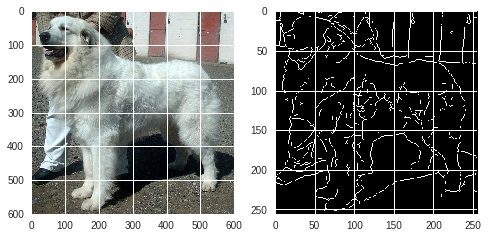

In [0]:
!curl -o test.jpg https://upload.wikimedia.org/wikipedia/commons/a/a3/Pyrenean_Mountain_Dog_600.jpg

source = skimage.io.imread('test.jpg')
result = edges(source.astype(np.float32))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(source)
ax[1].imshow(result)

## Dataset processing

It will take a fair amount of time to process. Beware automatic disconnection from Colaboratory.

In [0]:
# Code to read file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Try http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
link = 'https://drive.google.com/open?id=1Gidqta8-KNYVl8vCaPG6vwEV_Tjd0tlz'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('102flowers.tgz')

1Gidqta8-KNYVl8vCaPG6vwEV_Tjd0tlz


In [0]:
import tarfile
tf = tarfile.open("102flowers.tgz")
tf.extractall()

In [0]:
import os.path
if not os.path.exists('/content/png'):
  !mkdir png
  
input_dir = 'jpg'
output_dir = 'png'

In [0]:
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      filename_png = os.path.splitext(filename)[0] + '.png'
      input_path = os.path.join(input_dir, filename)
      output_path = os.path.join(output_dir, filename_png)
      if os.path.isfile(output_path): continue
      try:
        print('Processing: ' + filename)
        image = skimage.io.imread(input_path)
        image = edges(image.astype(np.float32))
        skimage.io.imsave(output_path, image)
      except Exception as e:
        print('Error: ' + str(e))

Processing: image_06837.jpg
Processing: image_07046.jpg
Processing: image_03812.jpg
Processing: image_05360.jpg
Processing: image_04607.jpg
Processing: image_07404.jpg
Processing: image_03237.jpg
Processing: image_00727.jpg
Processing: image_05521.jpg
Processing: image_02917.jpg
Processing: image_00415.jpg
Processing: image_06579.jpg
Processing: image_05024.jpg
Processing: image_06011.jpg
Processing: image_01695.jpg
Processing: image_03679.jpg
Processing: image_02444.jpg
Processing: image_07614.jpg
Processing: image_01720.jpg
Processing: image_01824.jpg
Processing: image_03612.jpg
Processing: image_06846.jpg
Processing: image_06923.jpg
Processing: image_01196.jpg
Processing: image_05145.jpg
Processing: image_07922.jpg
Processing: image_04559.jpg
Processing: image_03859.jpg
Processing: image_02227.jpg
Processing: image_00238.jpg
Processing: image_07297.jpg
Processing: image_08079.jpg
Processing: image_04245.jpg
Processing: image_04418.jpg
Processing: image_01551.jpg
Processing: image_06